#### Imports

In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from matplotlib import style
import seaborn as sns
from sqlalchemy import text, create_engine
import env
import wrangle as w
import explore as e

## Wrangle:
- Acquired data from Codeup MySQL database
    - Initial data frame contains 847,330 rows and 15 columns
- Prepare phase:
    - Dropped columns not needed
        - id, slack, created at, updated at, deleted at
    - Set index to date_time
        - dropped initial date and time columns after they were combined to date_time
    - Updated dtypes for cohort_id (int), start/end dates (datetime64)
    - Dropped rows containing ('/', 'toc', 'search/search_index.json')
        - These rows are landing pages and not lesson pages
- After prep, data frame has 766,351 rows and 8 columns

In [2]:
# acquire data from csv or MySQL
df = w.get_logs_data()

# prep data frame
df = w.prep_logs(df)

Found CSV


In [3]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
date_time,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


## Exploration

#### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [4]:
e.most_accessed_per_program(df)

List of most visited for Program 1:

main_path     sub_path    
spring        fundamentals    1426
content       laravel         1188
              html-css         949
javascript-i  introduction     812
html-css      css-i            752
dtype: int64
---------------------
List of most visited for Program 2:

main_path     sub_path    
spring        fundamentals    32967
html-css      css-i           30838
javascript-i  introduction    23404
html-css      css-ii          19604
javascript-i  bom-and-dom     14960
dtype: int64
---------------------
List of most visited for Program 3:

main_path       sub_path                 
classification  overview                     1785
1-fundamentals  modern-data-scientist.jpg    1655
                AI-ML-DL-timeline.jpg        1651
                1.1-intro-to-data-science    1633
classification  scale_features_or_not.svg    1590
dtype: int64
---------------------
List of most visited for Program 4:

main_path  sub_path
content    html-css    4
d

#### 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [5]:
visits = e.zealous_cohorts(df)

visits

cohort_id  num_visits    q1      q3  \
main_path sub_path                                                        
content   javascript                       13         176  5.50   28.50   
          gitbook                          13           7  1.00    2.00   
          javascript_ii                    13          81  7.00   12.00   
          laravel                          13         591  4.00  111.00   
          mysql                            13          83  3.50   21.00   
...                                       ...         ...   ...     ...   
nlp       regular-expressions              59         134  3.75   32.75   
          github_repo_language.gif         59         144  7.00   24.00   
css-ii    media-queries                    62           2  1.00    1.00   
appendix  coding-challenges                62         124  2.00   18.00   
jquery    mapbox-api                      135          87  4.00   12.00   

                                    upper_fence  
main_path sub_path                               
content   javascript                      97.50  
          gitbook                          5.00  
          javascript_ii                   27.00  
          laravel                        432.00  
          mysql                           73.50  
...                                         ...  
nlp       regular-expressions            119.75  
          github_repo_language.gif        75.00  
css-ii    media-queries                    1.00  
appendix  coding-challenges               66.00  
jquery    mapbox-api                      36.00  

[134 rows x 5 columns]

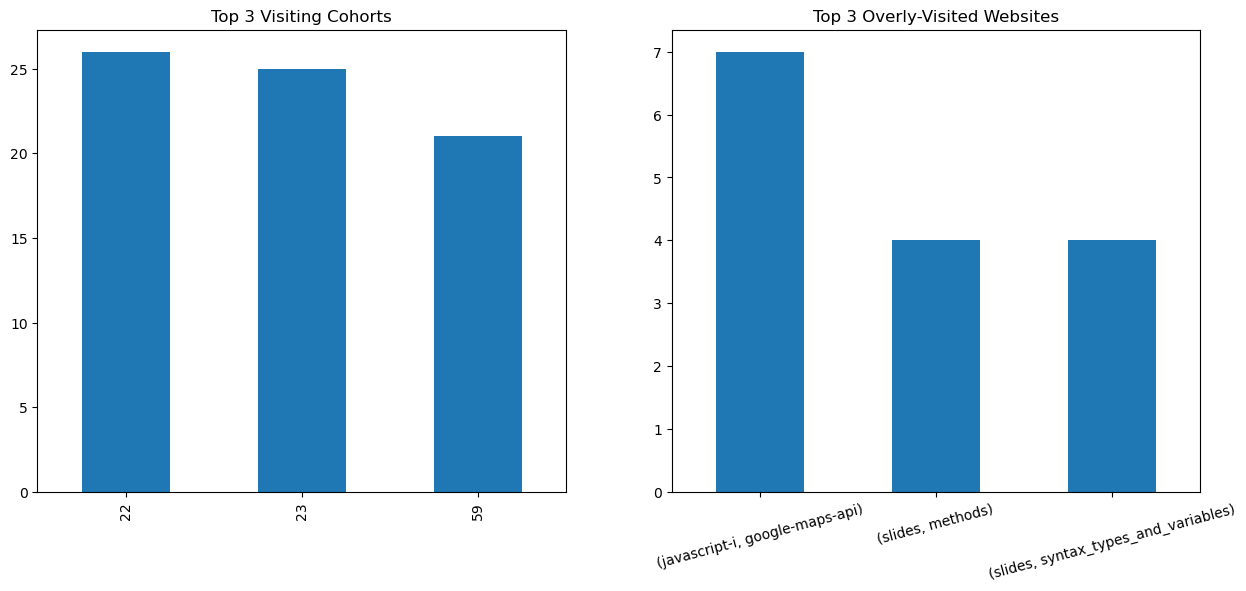

In [6]:
e.zealous_cohorts_viz(visits)

#### 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?


In [7]:
# isolating students who accessed the codeup websites between their start and stop dates
# students who, when active, accessed the curriculum
stud_acc_act = df[(df.index >= df.start_date) & (df.index <= df.end_date)]

In [8]:
# defined low access as less than 100 curriculum visits
# Approximately 100 days of instruction during 5 month course
# these students accessed the curriculum less than 1 per day 
low_access = stud_acc_act.user_id.value_counts() [stud_acc_act.user_id.value_counts() < 101].index

In [9]:
# turned low access students into a data frame
low_access_df = stud_acc_act[stud_acc_act.user_id.isin(low_access)]

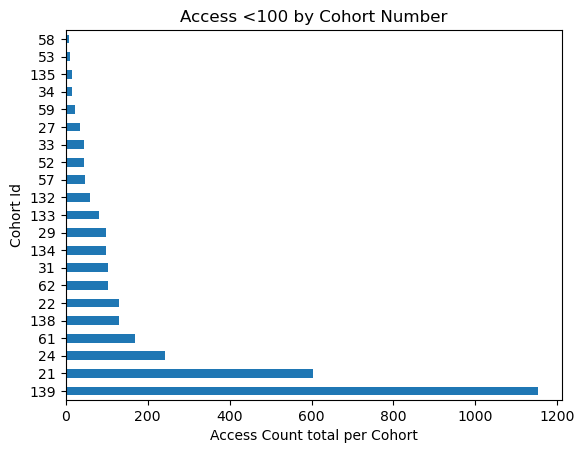

In [10]:
# plotting the total count of curriculum visits per cohort
low_access_df.cohort_id.value_counts().plot.barh()
plt.title('Access <100 by Cohort Number')
plt.ylabel('Cohort Id')
plt.xlabel('Access Count total per Cohort');

- The 2 cohorts who had the most amount of students who accessed the curriculum the least were:
    1. cohort 139 (Oberon) program 2
        - 85% of students are in this category
        - This was a new cohort so this makes sense and is **not** an anomaly
    2. cohort 21 (Sequoia) program 2
        - 39% of students are in this category

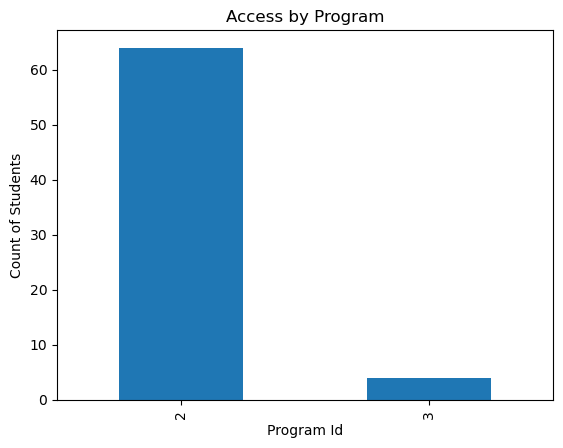

In [11]:
# plotting the count of students 
low_access_df.groupby('program_id').user_id.nunique().plot.bar()
plt.title('Access by Program')
plt.ylabel('Count of Students')
plt.xlabel('Program Id');


- Program 2 (WebDev) had the most students who accessed the curriculum the least

#### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [12]:
e.lessons_after_grad(df, 1)

user_id
main_path sub_path             
spring    fundamentals     1426
content   laravel          1188
          html-css          949

In [13]:
e.lessons_after_grad(df, 2)

,,user_id
main_path,sub_path,
spring,fundamentals,8862
html-css,css-i,4185
javascript-i,introduction,2473


In [14]:
e.lessons_after_grad(df, 3)

user_id
main_path      sub_path                          
sql            mysql-overview                 275
classification overview                       267
               scale_features_or_not.svg      220

#### 7. Which lessons are least accessed?

In [15]:
# this function isolates webdev students and iterates over the lesson name to get lesson count
e.least_accessed_web_dev(df)

Lessons accessed the least:
timeseries: 941
storytelling: 998
clustering: 1146
stats: 1367
capstone: 1717
design: 1805
mkdocs: 1865
python: 2049
detection: 2176
regression: 2392
sql: 2772


For WebDev, the following are the least accessed lessons:
- Storytelling
- Design
- MkDocs

In [16]:
# this function isolates DS students and iterates over the lesson name to get lesson count
e.least_accessed_ds(df)

Lessons accessed the least:
topics: 1278
ml: 1655
nlp: 3207
storytelling: 3296
timeseries: 3313


For DS, the follwing are the least accessed lessons:
- Machine learning
- Natural Language Processing (NLP)
- Storytelling